In [1]:
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial

In [3]:
import jax_ca_utils as ca

## Gradient Descent

### Target and Initial States

In [4]:
rng = np.random.default_rng(seed=101)

Number of steps to run the CA for.

In [5]:
N_STEPS = 20

We'll use a known rule to generate target data:

In [6]:
rule_113 = ca.ca.rule_arr(
    113, 
    idxs=tuple(np.arange(8)), 
    perbs=tuple(1e-6 * np.ones(8))
)[:, 0]

Then use a random rule as a starting point for optimisation:

In [7]:
random_rule = rng.uniform(0.25, 0.75, 8)

And a fixed random initial state:

In [8]:
random_state = rng.uniform(1e-8, 1-1e-8, (2, 100))
random_state = np.log(ca.state_to_joint(random_state))

### Utility Functions

This function converts a 1d-rule array to a joint probabilty, then run the CA with this rule:

In [9]:
@partial(jax.jit, static_argnames=("steps",))
def run_model(rule_arr, state, steps):
    
    ra = jnp.stack(
        (rule_arr, 1.- rule_arr)
    ).T
    ra = jnp.log(ra)
    
    j = ca.rule_to_joint(ra, log_prob=True)
    
    return ca.run_model(j, state, steps, log_prob=True)

#### Target Output

We can them generate a target output, the probability of individual states generated by rule 113:

In [10]:
target = run_model(rule_113, random_state, N_STEPS)
target = jnp.exp(ca.state_probabilities(target)[:, 1])

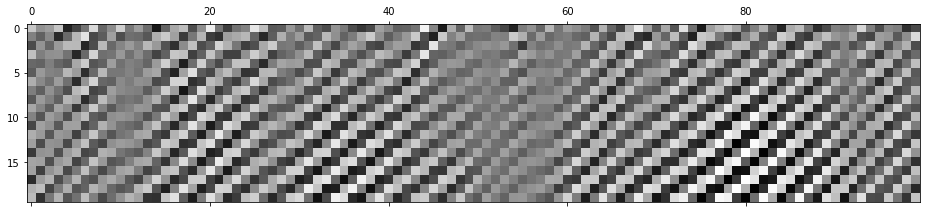

In [11]:
plt.matshow(target, cmap="gray");

#### Optimisation Function

This function then run the model and calculates the MSE between the generated series and the target.

In [12]:
@partial(jax.jit, static_argnames=("steps",))
def diff_run(rule_arr, state, steps):
    
    ts = run_model(rule_arr, state, steps)
    
    loss = target - jnp.exp(
        ca.state_probabilities(ts)[:, 1]
    )
    loss = jnp.mean(loss ** 2)
    
    return loss

For the actual optimisation loop we use basic gradient descent on the CA rule probabilities. Since these will be converted to log probabilities we clip them inside the range ``(1e-8, 1 - 1e-8)``.

In [13]:
@partial(
    jax.jit, 
    static_argnames=("steps", "opt_steps")
)
def opt(
    rule, state, steps, opt_steps, epsilon=1e-4
):
    
    def inner_opt(r, x):
        
        loss, g = jax.value_and_grad(diff_run)(r, state, steps)
        r = r - epsilon * g
        r = np.clip(r, 1e-8, 1 - 1e-8)
        
        ts = run_model(r, state, steps)
        p = ca.state_probabilities(ts)[:, 1]
        
        return r, (p, loss, g, r)
    
    return jax.lax.scan(
        inner_opt, rule, None, length=opt_steps
    )

We then run the gradient descent loop for 25k steps (this may take a couple minutes based on your hardware) starting from the random initial rule.

In [14]:
_, (probs, loss, grads, rules) = opt(
    random_rule, random_state, N_STEPS, 25_001, epsilon=1e-2
)

## Results

The optimisation process does reach a ruleset very close to the target (~$\pm 10^{-7}$).

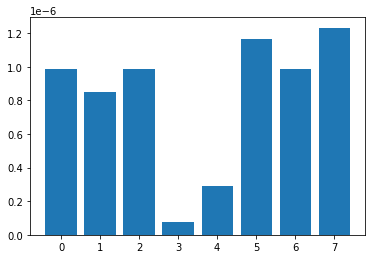

In [15]:
plt.bar(np.arange(8), np.abs(rules[-1] - rule_113));

Plotting the MSE over training steps we can see how the MSE improves over training, though the shape of the training curve is interesting, given how it slows until quickly improving as we close in on the target rule.
We see this shape reflected in the gradient for each of the probabilities that make up the update rule, they are relatively flat until we reach the target rule.

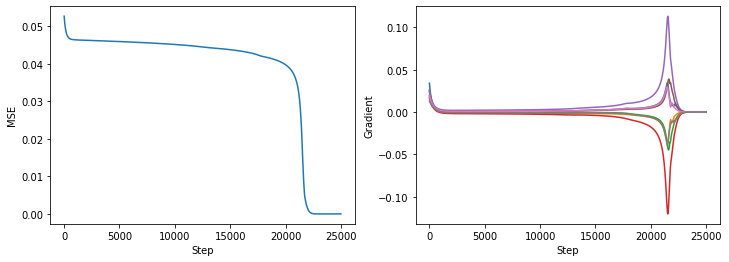

In [16]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss)
ax[0].set_xlabel("Step")
ax[0].set_ylabel("MSE")

ax[1].plot(grads)
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Gradient");

We can also visualise the series generated by succesive rules over training.

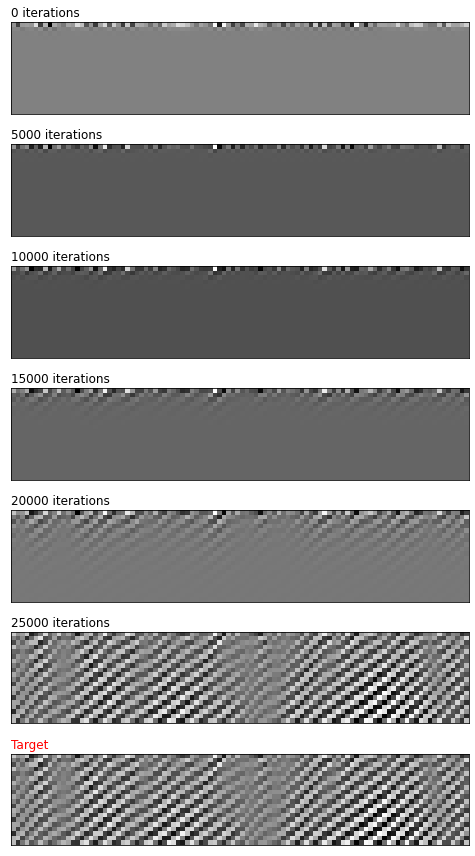

In [17]:
f, ax = plt.subplots(7, 1, figsize=(10, 12))

for i, j in enumerate(range(0, 25_001, 5_000)):
    ax[i].matshow(jnp.exp(probs[j]), cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"{j} iterations", loc="left")
    
ax[-1].matshow(target, cmap="gray")
ax[-1].set_xticks([])
ax[-1].set_yticks([])
ax[-1].set_title("Target", loc="left", c="red")

plt.tight_layout()